In [41]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from joblib import Parallel, delayed
import pandas as pd

In [42]:
circle_data = [
    {'lat': 41.14486, 'lon': -74.87798, 'diameter': 804.67},
    {'lat': 41.29262, 'lon': -75.37592, 'diameter': 635.6893},
    {'lat': 41.72997, 'lon': -74.83641, 'diameter': 503.72342},
    {'lat': 42.029096, 'lon': -74.382995, 'diameter': 397.50698},
    {'lat': 42.272627, 'lon': -74.042667, 'diameter': 313.8213},
    {'lat': 42.275847, 'lon': -73.671496, 'diameter': 247.83836},
    {'lat': 42.288835, 'lon': -73.359477, 'diameter': 194.73014},
    {'lat': 42.320238, 'lon': -73.110613, 'diameter': 152.8873},
    {'lat': 42.404492, 'lon': -72.975152, 'diameter': 120.7005},
    {'lat': 42.43178423219, 'lon': -72.829357748827, 'diameter': 93.91513577841688},
    {'lat': 42.437035601116, 'lon': -72.723873641505, 'diameter': 73.15911301973783},
    {'lat': 42.486806800325, 'lon': -72.665907935874, 'diameter': 56.70865456654077},
    {'lat': 42.525542962371, 'lon': -72.611355509733, 'diameter': 43.67048102540763},
]

In [43]:
27.135646305571 * 1.60934

43.67048102540763

In [44]:
# Function to convert kilometers to degrees latitude or longitude
def km_to_deg_lat(km):
    return km / 111.32

def km_to_deg_lon(km, lat):
    return km / (111.32 * np.cos(np.radians(lat)))


# Convert degrees to kilometers using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2)**2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate the bearing from point 1 to point 2
def calculate_bearing(lat1, lon1, lat2, lon2):
    dlon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
    bearing = np.arctan2(x, y)

    return bearing

# Calculate the area overlap between two circles
def area_overlap(circle1, circle2):
    lat1, lon1, radius1 = circle1
    lat2, lon2, radius2 = circle2
    distance = haversine(lat1, lon1, lat2, lon2)

    if distance >= radius1 + radius2:
        return 0  # No overlap
    if distance <= abs(radius1 - radius2):
        return np.pi * min(radius1, radius2) ** 2  # One circle is contained in the other
    
    # Calculate the overlap area between two circles
    r1_sq = radius1 ** 2
    r2_sq = radius2 ** 2
    d_sq = distance ** 2
    
    part1 = r1_sq * np.arccos((d_sq + r1_sq - r2_sq) / (2 * distance * radius1))
    part2 = r2_sq * np.arccos((d_sq + r2_sq - r1_sq) / (2 * distance * radius2))
    part3 = 0.5 * np.sqrt((-distance + radius1 + radius2) * (distance + radius1 - radius2) * 
                          (distance - radius1 + radius2) * (distance + radius1 + radius2))
    
    return part1 + part2 - part3


In [45]:
def plot_circle_data(circle_data, figsize=(20,20)):
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot each circle
    for i, circle in enumerate(circle_data):
        lat = circle['lat']
        lon = circle['lon']
        radius_km = circle['diameter'] / 2  # Convert diameter to radius in km

        # Draw the circle with correct lat/lon scaling
        circle_lat_radius = km_to_deg_lat(radius_km)
        circle_lon_radius = km_to_deg_lon(radius_km, lat)

        # Draw the circle
        ellipse = plt.Circle((lon, lat), radius=circle_lon_radius, color='b', fill=False, lw=2)
        ax.add_patch(ellipse)

        # Plot the center point
        ax.scatter(lon, lat, color='r', s=100, label=f'Circle {i+1}' if i == 0 else None)

        # Add a label for the circle
        ax.text(lon, lat, f'Circle {i+1}', fontsize=12, ha='right')

    # Formatting the plot
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Center Points and Circles for Each Data Point')
    plt.legend(loc='upper right')
    plt.grid(True)
    # plt.show()
    return plt


In [46]:
def circles_to_circle_data(circles, circle_data):
    circle_data_sim = [{"lat": lat, "lon": lon, "diameter": radius * 2} for lat, lon, radius in circles]
    circle_data_sim.insert(0, circle_data[0])
    return circle_data_sim

<module 'matplotlib.pyplot' from 'C:\\Users\\chiefastro\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

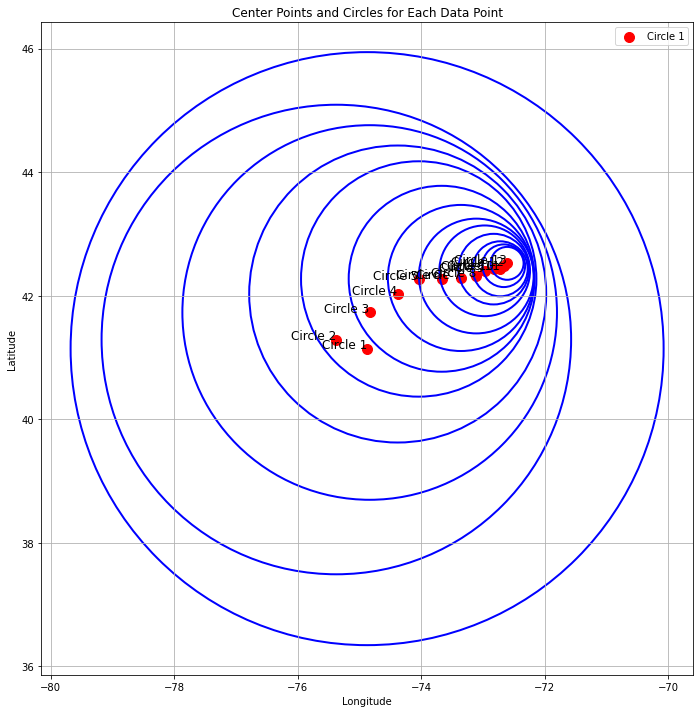

In [70]:
plot_circle_data(circle_data, figsize=(12,12))

In [48]:
def generate_kml(circle_data, kml_file_path="circles.kml"):
    # Rebuild the KML content with the adjusted longitudes
    kml_content = '''<?xml version="1.0" encoding="UTF-8"?>
    <kml xmlns="http://www.opengis.net/kml/2.2">
    <Document>
    '''

    # Iterate over the circles to add points and corrected circles to KML
    for circle in circle_data:
        lat = circle['lat']
        lon = circle['lon']
        diameter_km = circle['diameter']

        # Add center point
        kml_content += f'''
        <Placemark>
            <name>Center ({lat}, {lon})</name>
            <Point>
                <coordinates>{lon},{lat},0</coordinates>
            </Point>
        </Placemark>
        '''

        # Calculate radius in degrees
        radius_deg = km_to_deg_lat(diameter_km / 2)
        radius_lon_deg = km_to_deg_lon(diameter_km / 2, lat)
        num_points = 100  # number of points to create the circle
        angles = [i * (360 / num_points) for i in range(num_points)]

        # Create corrected circle points
        circle_coords = ''
        for angle in angles:
            edge_lat = lat + (radius_deg * np.sin(np.radians(angle)))
            edge_lon = lon + (radius_lon_deg * np.cos(np.radians(angle)))
            circle_coords += f'{edge_lon},{edge_lat},0 '  # add the coordinates

        # Create a polygon representing the circle edge
        kml_content += f'''
        <Placemark>
            <name>Circle Edge</name>
            <Polygon>
                <outerBoundaryIs>
                    <LinearRing>
                        <coordinates>{circle_coords}</coordinates>
                    </LinearRing>
                </outerBoundaryIs>
            </Polygon>
        </Placemark>
        '''

    # Closing KML Document
    kml_content += '''
    </Document>
    </kml>
    '''

    # Save the corrected KML file
    with open(kml_file_path, "w") as file:
        file.write(kml_content)


In [49]:
# Single Simulation

# Pick a random start day based on exponential weighting
def pick_random_start_day(circle_data, exp_decay_start_day=0.1):
    # Create an exponential weight for each day
    days = np.arange(len(circle_data) - 1)
    weights = np.exp(-exp_decay_start_day * (len(circle_data) - 1 - days))  # More weight for recent days
    weights /= weights.sum()  # Normalize the weights
    
    start_day = np.random.choice(days, p=weights)
    return start_day


def single_sim(
    circle_data, true_lat, true_lon, exp_decay=0.25, distance_mean=0.15, distance_stddev=0.05, 
    bearing_stddev=5, max_retries=1000, exp_decay_start_day=0.1, exp_decay_start_day_discount=0.3, edge_ratio=0.1
):
    circles = []
    # Pick a random starting day
    start_day_index = pick_random_start_day(circle_data, exp_decay_start_day=exp_decay_start_day)
    lat, lon, radius = circle_data[start_day_index]['lat'], circle_data[start_day_index]['lon'], circle_data[start_day_index]['diameter'] / 2  # Starting point (random day)
    
    metric_total = 0
    for i, next_circle in enumerate(circle_data[start_day_index + 1:]):  # Simulate from the day after the random starting day to the last day
        new_radius = next_circle["diameter"] / 2
        prev_radius = circle_data[start_day_index + i]["diameter"] / 2
        # Generate a new circle until it meets the containment condition
        circle_is_valid = False
        counter = 0
        while not circle_is_valid and counter < max_retries:
            new_lat, new_lon = generate_new_circle(lat, lon, true_lat, true_lon, new_radius, prev_radius, distance_mean=distance_mean, distance_stddev=distance_stddev, bearing_stddev=bearing_stddev)
            circle_is_valid = is_valid_circle(lat, lon, radius, new_lat, new_lon, new_radius, true_lat, true_lon, edge_ratio=edge_ratio)
            counter += 1
            
        if counter >= max_retries:
            return 0, circles

        # Append the new circle
        next_circle_sim = (new_lat, new_lon, new_radius)
        circles.append(next_circle_sim)

        # Update lat and lon for the next step (next day)
        lat, lon, radius = new_lat, new_lon, new_radius  # New location becomes the starting point for the next iteration

        # circle overlap metrics
        next_circle_real = (next_circle["lat"], next_circle["lon"], next_circle["diameter"] / 2)
        overlap_area = area_overlap(next_circle_real, next_circle_sim)
        true_area = area_overlap(next_circle_real, next_circle_real)
        overlap_percent = (overlap_area / true_area)
        metric = overlap_percent
        
        # use number of tries to find valid circles as metric
        # metric = (max_retries - counter) / max_retries
        
        # apply exponential decay
        metric_decayed = np.exp(-exp_decay * (len(circle_data[start_day_index + 1:]) - i)) * metric
        # discount based on counter
        metric_decayed = (1 - np.exp(-0.5 * np.log(counter + 1))) * metric_decayed
        metric_total += metric_decayed
        
    # discount overlap_total when start_day_index is later
    metric_total = np.exp(-exp_decay_start_day_discount * (start_day_index)) * metric_total
        
    return metric_total, circles


def is_valid_circle(lat, lon, radius, new_lat, new_lon, new_radius, true_lat, true_lon, edge_ratio=0.1):
    # Check if true lat lon are inside and not too close to edge
    dist_to_true = haversine(new_lat, new_lon, true_lat, true_lon)
    truth_contained_check = dist_to_true <= new_radius * (1 - edge_ratio)
    if truth_contained_check:

        # Check if the new circle is entirely within the previous circle
        overlap = area_overlap((lat, lon, radius), (new_lat, new_lon, new_radius))
        area_new = np.pi * new_radius ** 2
        overlap_check = np.isclose(overlap, area_new, atol=1e-3)
    
        return overlap_check
    return False

# Function to generate a new circle and check if it is within previous circles
def generate_new_circle(lat, lon, true_lat, true_lon, radius, prev_radius, distance_mean=0.15, distance_stddev=0.05, bearing_stddev=5):
    # get distance from prev to true
    dist_to_true = haversine(lat, lon, true_lat, true_lon)
    
    # Calculate movement toward the true location with normal distribution centered at 15%
    distance_to_move = np.random.normal(distance_mean, distance_stddev) * dist_to_true
    
    # keep truth away from edges to match observations
    # require that distance_to_move > diff of prev radius and this radius
    # dist_checks_out = False
    # counter = 0
    # while not dist_checks_out and counter < 10:
    #     distance_to_move = np.random.normal(distance_mean, distance_stddev) * dist_to_true
    #     dist_checks_out = distance_to_move <= (prev_radius - radius)
    #     counter += 1

    # Calculate the bearing (direction) toward the true location
    bearing = calculate_bearing(lat, lon, true_lat, true_lon)

    # Add noise to the bearing
    noise = np.random.normal(0, np.radians(bearing_stddev))  # Noise with a standard deviation of 5 degrees
    noisy_bearing = bearing + noise

    # Calculate the movement in km in the direction of the true location
    dx = distance_to_move * np.sin(noisy_bearing)
    dy = distance_to_move * np.cos(noisy_bearing)
    # dx = dist_to_true * distance_mean * np.cos(bearing)
    # dy = dist_to_true * distance_mean * np.sin(bearing)
    

    # Update the center location using the calculated bearing
    new_lat = lat + km_to_deg_lat(dy)  # Convert km to degrees latitude
    new_lon = lon + km_to_deg_lon(dx, lat)  # Convert km to degrees longitude
    
    return new_lat, new_lon


In [50]:
# Higher level simulation helpers

# Simulation for one "true" location
def simulate_for_true_location(
    true_lat, true_lon, num_simulations=100, exp_decay=0.25, 
    distance_mean=0.15, distance_stddev=0.05, bearing_stddev=5, max_retries=1000, 
    exp_decay_start_day=0.1, exp_decay_start_day_discount=0.3, edge_ratio=0.1
):
    final_lat = circle_data[-1]['lat']
    final_lon = circle_data[-1]['lon']
    final_radius = circle_data[-1]['diameter'] / 2  # Diameter to radius (in km)
    final_circle = (final_lat, final_lon, final_radius)
    
    total_metric = 0
    for _ in range(num_simulations):
        metric, circles = single_sim(
            circle_data, true_lat, true_lon, 
            exp_decay=exp_decay, distance_mean=distance_mean, 
            distance_stddev=distance_stddev, bearing_stddev=bearing_stddev, 
            max_retries=max_retries, exp_decay_start_day=exp_decay_start_day,
            exp_decay_start_day_discount=exp_decay_start_day_discount, edge_ratio=edge_ratio,
        )
        total_metric += metric
    average_metric = total_metric / num_simulations
    return average_metric

def compute_prob_grid(
    probability_grid, lat_grid, lon_grid, final_lat, final_lon, final_radius, num_simulations, 
    parallel=True, exp_decay=0.25, distance_mean=0.15, distance_stddev=0.05, bearing_stddev=5, 
    max_retries=1000, exp_decay_start_day=0.1, exp_decay_start_day_discount=0.3, edge_ratio=0.1
):
    if parallel:
        valid_i_js = []
        for i, lat in enumerate(lat_grid):
            for j, lon in enumerate(lon_grid):
                # Check if the point is within the final circle
                distance_to_final_circle = haversine(lat, lon, final_lat, final_lon)
                if distance_to_final_circle <= final_radius:
                    # Run the simulation for this "true" location
                    # probability_grid[i, j] = simulate_for_true_location(lat, lon, num_simulations)
                    valid_i_js.append(({"i": i, "lat": lat, "j": j, "lon": lon}))

        probs = Parallel(n_jobs=-1, verbose=10)(delayed(simulate_for_true_location)(
            d["lat"], d["lon"], num_simulations, 
            exp_decay=exp_decay, distance_mean=distance_mean, 
            distance_stddev=distance_stddev, bearing_stddev=bearing_stddev, 
            max_retries=max_retries, exp_decay_start_day=exp_decay_start_day,
            exp_decay_start_day_discount=exp_decay_start_day_discount, edge_ratio=edge_ratio,
        ) for d in valid_i_js)

        for k in range(len(probs)):
            i = valid_i_js[k]["i"]
            j = valid_i_js[k]["j"]
            probability_grid[i, j] = probs[k]
    else:
        for i, lat in enumerate(lat_grid):
            for j, lon in enumerate(lon_grid):
                # Check if the point is within the final circle
                distance_to_final_circle = haversine(lat, lon, final_lat, final_lon)
                if distance_to_final_circle <= final_radius:
                    # Run the simulation for this "true" location
                    probability_grid[i, j] = simulate_for_true_location(
                        lat, lon, num_simulations, 
                        exp_decay=exp_decay, distance_mean=distance_mean, 
                        distance_stddev=distance_stddev, bearing_stddev=bearing_stddev, 
                        max_retries=max_retries, exp_decay_start_day=exp_decay_start_day,
                        exp_decay_start_day_discount=exp_decay_start_day_discount, edge_ratio=edge_ratio,
                    )
        
    
    # normalize probs
    # probability_grid = np.exp(probability_grid)
    probability_grid = probability_grid / probability_grid.sum()
    
    return probability_grid


def get_grids(circle_data, grid_resolution=50):
    final_lat = circle_data[-1]['lat']
    final_lon = circle_data[-1]['lon']
    final_radius = circle_data[-1]['diameter'] / 2  # Diameter to radius (in km)
    
    # Calculate the radius in degrees for the grid boundaries
    lat_extent = km_to_deg_lat(final_radius)
    lon_extent = km_to_deg_lon(final_radius, final_lat)

    # Create a grid that covers the entire final circle area
    lat_grid = np.linspace(final_lat - lat_extent, final_lat + lat_extent, grid_resolution)
    lon_grid = np.linspace(final_lon - lon_extent, final_lon + lon_extent, grid_resolution)
    
    probability_grid = np.zeros((grid_resolution, grid_resolution))

    return (
        probability_grid, lat_grid, lon_grid, 
        final_lat, final_lon, final_radius
    )

In [51]:
# Full Simulation
def run_grid_simulation(
    circle_data, grid_resolution=50, num_simulations=100, parallel=True, 
    exp_decay=0.25, distance_mean=0.15, distance_stddev=0.05, bearing_stddev=5, 
    max_retries=1000, exp_decay_start_day=0.1, exp_decay_start_day_discount=0.3, edge_ratio=0.1
):
    (
        probability_grid, lat_grid, lon_grid, 
        final_lat, final_lon, final_radius
    ) = get_grids(circle_data, grid_resolution)
    print(f"Shape of probability_grid: {probability_grid.shape}")
    print(f"{probability_grid.shape[0] * probability_grid.shape[1]} grid points")
    print(f"{probability_grid.shape[0] * probability_grid.shape[1] * num_simulations} total simulations")
    probability_grid = compute_prob_grid(
        probability_grid, lat_grid, lon_grid, 
        final_lat, final_lon, final_radius, 
        num_simulations, parallel=parallel,
        exp_decay=exp_decay, distance_mean=distance_mean, distance_stddev=distance_stddev, bearing_stddev=bearing_stddev, 
        max_retries=max_retries, exp_decay_start_day=exp_decay_start_day, exp_decay_start_day_discount=exp_decay_start_day_discount,
        edge_ratio=edge_ratio,
    )
    
    return lat_grid, lon_grid, probability_grid


In [52]:
def visualize_prob_map(circle_data, lat_grid, lon_grid, probability_grid):
    # Find the index of the maximum probability value
    max_index = np.unravel_index(np.argmax(probability_grid), probability_grid.shape)

    # Get the corresponding latitude and longitude
    max_lat = lat_grid[max_index[0]]  # Row index corresponds to latitude
    max_lon = lon_grid[max_index[1]]  # Column index corresponds to longitude

    # Print the results
    print(f'Maximum Probability: {probability_grid[max_index]}')
    print(f'{max_lat}, {max_lon}')

    # Plot the probability grid as a heatmap
    plt.figure(figsize=(10, 8))
    plt.contourf(lon_grid, lat_grid, probability_grid, cmap='hot', levels=100)
    plt.colorbar(label='Percent Area Overlap')
    plt.title('Probability Map Based on Simulated Circle Overlap')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Create the circle for the known location
    final_lat = circle_data[-1]['lat']
    final_lon = circle_data[-1]['lon']
    final_radius = circle_data[-1]['diameter'] / 2  # Diameter to radius (in km)
    lat_to_deg = km_to_deg_lat(final_radius)
    lon_to_deg = km_to_deg_lon(final_radius, final_lat)  # Adjusted for latitude

    circle = plt.Circle((final_lon, final_lat), lon_to_deg, color='blue', fill=False, linestyle='dashed', linewidth=2)

    # Add the circle to the plot
    # plt.gca().add_artist(circle)

    # Plot the maximum probability location with a big X
    plt.scatter(max_lon, max_lat, color='red', marker='X', s=200, label='Max Probability Location')

    # Add legend
    plt.legend()

    # Set the limits of the plot for better visibility
    plt.xlim(np.min(lon_grid), np.max(lon_grid))
    plt.ylim(np.min(lat_grid), np.max(lat_grid))

    # Set equal aspect ratio to ensure circles appear as circles
    # plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

In [53]:
# Run the grid simulation
lat_grid, lon_grid, probability_grid = run_grid_simulation(
    circle_data, grid_resolution=50, num_simulations=200, parallel=True,
    exp_decay=0.8, distance_mean=0.2, distance_stddev=0.1, bearing_stddev=5,
    max_retries=100, exp_decay_start_day=0.1, exp_decay_start_day_discount=0.3, edge_ratio=0.15
)

Shape of probability_grid: (50, 50)
2500 grid points
500000 total simulations


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

In [67]:
from scipy.ndimage import gaussian_filter

def smooth_probability_grid(probability_grid, sigma_percent=0.03):
    # Get grid dimensions (number of rows and columns)
    nrows, ncols = probability_grid.shape

    # Calculate sigma as percent of the grid size
    # Apply different sigma for rows and columns if needed (anisotropic smoothing)
    sigma_row = sigma_percent * nrows
    sigma_col = sigma_percent * ncols

    # Apply Gaussian smoothing to the probability grid
    return gaussian_filter(probability_grid, sigma=[sigma_row, sigma_col])


In [68]:
smoothed_probability_grid = smooth_probability_grid(probability_grid)

Maximum Probability: 0.000889567836100764
42.561570220544596, -72.47556315509254


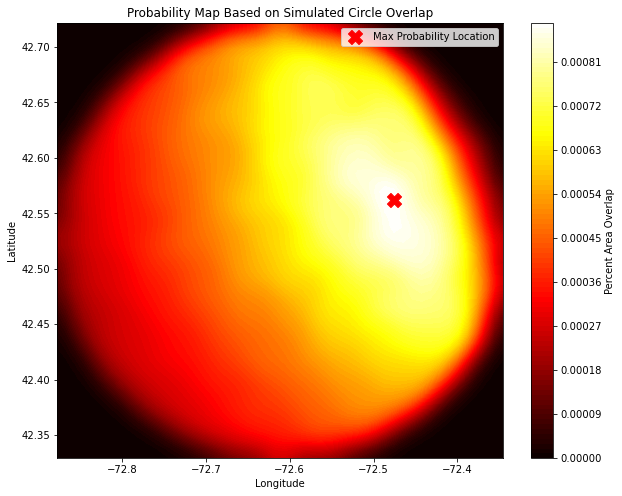

In [69]:
visualize_prob_map(circle_data, lat_grid, lon_grid, smoothed_probability_grid)

In [16]:
def plot_circle_data(circle_data, figsize=(20,20), true_circle_data=None):
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot each circle
    for i, circle in enumerate(circle_data):
        lat = circle['lat']
        lon = circle['lon']
        radius_km = circle['diameter'] / 2  # Convert diameter to radius in km

        # Draw the circle with correct lat/lon scaling
        circle_lat_radius = km_to_deg_lat(radius_km)
        circle_lon_radius = km_to_deg_lon(radius_km, lat)

        # Draw the circle
        ellipse = plt.Circle((lon, lat), radius=circle_lon_radius, color='b', fill=False, lw=2)
        ax.add_patch(ellipse)

        # Plot the center point
        ax.scatter(lon, lat, color='r', s=100, label=f'Circle {i+1}' if i == 0 else None)

        # Add a label for the circle
        ax.text(lon, lat, f'Circle {i+1}', fontsize=12, ha='right')
        
    if true_circle_data is not None:
        for i, circle in enumerate(true_circle_data):
            lat = circle['lat']
            lon = circle['lon']
            radius_km = circle['diameter'] / 2  # Convert diameter to radius in km

            # Draw the circle with correct lat/lon scaling
            circle_lat_radius = km_to_deg_lat(radius_km)
            circle_lon_radius = km_to_deg_lon(radius_km, lat)

            # Draw the circle
            ellipse = plt.Circle((lon, lat), radius=circle_lon_radius, color='g', fill=False, lw=2)
            ax.add_patch(ellipse)

            # Plot the center point
            ax.scatter(lon, lat, color='orange', s=100, label=f'True Circle {i+1}' if i == 0 else None)

            # Add a label for the circle
            ax.text(lon, lat, f'Circle {i+1}', fontsize=12, ha='right')
        

    # Formatting the plot
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Center Points and Circles for Each Data Point')
    plt.legend(loc='upper right')
    plt.grid(True)
    # plt.show()
    return plt


overlap_area: 0


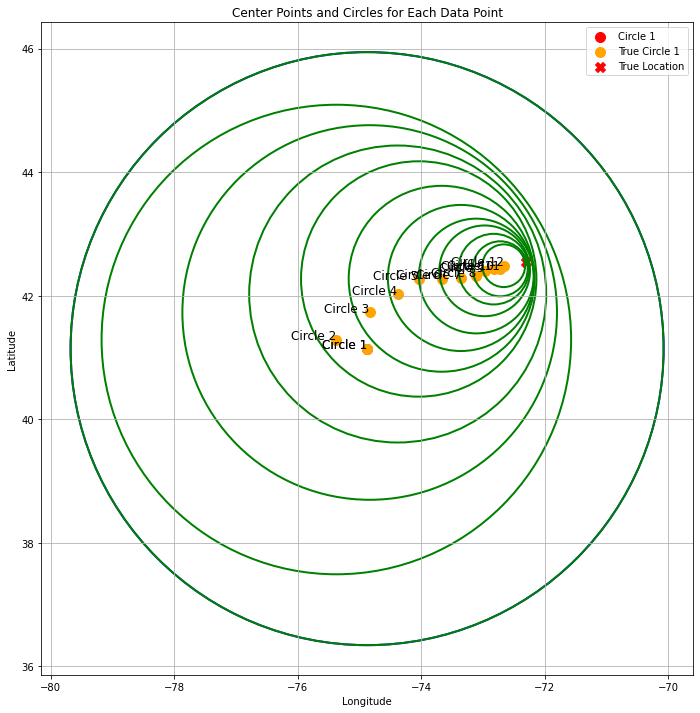

In [17]:
# true_lat, true_lon = 42.437035601116, -72.723873641505
# true_lat, true_lon = 42.48069, -72.49249
# true_lat, true_lon = 42.44141688214135, -72.78321895963187
# true_lat, true_lon = 42.554873, -72.313676
# true_lat, true_lon = 42.320238, -73.110613
true_lat, true_lon = 42.320238, -73.110613 # west edge, too close to be true
true_lat, true_lon = 42.554873, -72.313676 # northeast edge, too close to be true
# true_lat, true_lon = 42.457202, -72.393864 # shutesbury guess

overlap_area, circles = single_sim(
    circle_data, true_lat, true_lon, 
    exp_decay=0.8, distance_mean=0.2, distance_stddev=0.1, bearing_stddev=5,
    max_retries=10000, exp_decay_start_day=0.1, exp_decay_start_day_discount=0.3
)

print(f"overlap_area: {overlap_area}")
circle_data_sim = circles_to_circle_data(circles, circle_data)
plt = plot_circle_data(circle_data_sim, figsize=(12,12), true_circle_data=circle_data)
# Plot the maximum probability location with a big X
plt.scatter(true_lon, true_lat, color='red', marker='X', s=100, label='True Location')

# Add legend
plt.legend()
plt.show()

In [18]:
circle_data_sim

[{'lat': 41.14486, 'lon': -74.87798, 'diameter': 804.67}]

In [19]:
generate_kml(circle_data_sim, kml_file_path="circles_sim.kml")

In [20]:
true_lat, true_lon = 42.320238, -73.110613 # west edge, too close to be true

west = []
for _ in tqdm(range(300)):
    overlap_area, circles = single_sim(
        circle_data, true_lat, true_lon, 
        exp_decay=0.8, distance_mean=0.2, distance_stddev=0.1, bearing_stddev=5,
        max_retries=1000, exp_decay_start_day=0.1, exp_decay_start_day_discount=0.3
    )
    west.append(overlap_area)

sum(west) / len(west)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:03<00:00, 88.67it/s]


0.009620585900143534

In [21]:
true_lat, true_lon = 42.554873, -72.313676 # northeast edge, too close to be true

east = []
for _ in tqdm(range(300)):
    overlap_area, circles = single_sim(
        circle_data, true_lat, true_lon, 
        exp_decay=0.8, distance_mean=0.2, distance_stddev=0.1, bearing_stddev=5,
        max_retries=1000, exp_decay_start_day=0.1, exp_decay_start_day_discount=0.3
    )
    east.append(overlap_area)

sum(east) / len(east)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:20<00:00, 14.53it/s]


0.013913493124880504

In [22]:
true_lat, true_lon = 42.457202, -72.393864 # shutesbury guess

east = []
for _ in tqdm(range(300)):
    overlap_area, circles = single_sim(
        circle_data, true_lat, true_lon, 
        exp_decay=0.8, distance_mean=0.2, distance_stddev=0.1, bearing_stddev=5,
        max_retries=1000, exp_decay_start_day=0.1, exp_decay_start_day_discount=0.3
    )
    east.append(overlap_area)

sum(east) / len(east)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:08<00:00, 33.94it/s]


0.029457810977395363